# Result
This file contains result of machine learning train done at `training.ipynb`

In [19]:
import torch
import torchvision

from torch import nn
import torch.utils.data as data
import torchvision.transforms as transforms
from torchinfo import summary

from tqdm.auto import tqdm
from typing import Dict, List
import matplotlib.pyplot as plt
from timeit import default_timer as timer
import numpy as np
import os
from PIL import Image
import re
import json

## Model Definition

In [20]:
class Block(nn.Module):
    def __init__(self, dimension):
        super().__init__()
        self.conv1 = nn.Conv3d(dimension, dimension, 3, padding='same')
        self.conv2 = nn.Conv3d(dimension, dimension, 3, padding='same')
        self.norm1 = nn.BatchNorm3d(dimension)
        self.norm2 = nn.BatchNorm3d(dimension)
        self.act = nn.GELU()
    
    def forward(self, x):
        identity = x

        x = self.conv1(x)
        x = self.norm1(x)
        x = self.act(x)

        x = self.conv2(x)
        x = self.norm2(x)

        x = x + identity

        x = self.act(x)

        return x

In [21]:
class TempResNet(nn.Module):
    def __init__(self, channel, depth):
        super().__init__()
        self.depth = depth
        self.encode = nn.Conv3d(channel, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
        self.norm = nn.BatchNorm3d(64)
        self.expand1 = nn.Sequential(
            nn.Conv3d(64, 128, 1),
            nn.BatchNorm3d(128)
        )
        self.expand2 = nn.Sequential(
            nn.Conv3d(128, 256, 1),
            nn.BatchNorm3d(256)
        )
        self.expand3 = nn.Sequential(
            nn.Conv3d(256, 512, 1),
            nn.BatchNorm3d(512)
        )
        self.act = nn.GELU()

        self.max_pool1 = nn.MaxPool3d(kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=(0, 1, 1))
        self.max_pool2 = nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0)

        self.block1 = Block(64)
        self.block2 = Block(128)
        self.block3 = Block(256)
        self.block4 = Block(512)

        self.ave_pool = nn.AdaptiveAvgPool3d((1, 1, 1))

        self.flatten = nn.Flatten()
        self.fc = nn.Linear(512, depth*21*3)

    def forward(self, x):
        x = self.encode(x)
        x = self.norm(x)
        x = self.act(x)
        x = self.max_pool1(x)
        x = self.block1(x)
        x = self.max_pool2(x)

        x = self.expand1(x)
        x = self.block2(x)
        x = self.max_pool2(x)

        x = self.expand2(x)
        x = self.block3(x)
        x = self.max_pool2(x)

        x = self.expand3(x)
        x = self.block4(x)

        x = self.ave_pool(x)
        x = self.flatten(x)

        x = self.fc(x)

        x = x.view(-1, self.depth, 21, 3)

        return x

## Constants and Helper Function

In [22]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
thresholds = [i for i in range(0, 80, 5)]

In [23]:
def draw_bone(start, end, ax, c='g'):
    xs = [start[0], end[0]]
    ys = [start[1], end[1]]
    zs = [start[2], end[2]]
    ax.plot(xs, ys, zs, color=c)

## Dataset Class

In [24]:
"""# Load Dataset"""

class Dataset(data.Dataset):

    def __init__(self, root='./', transform=None, test=False):
        self.root = root#os.path.expanduser(root)
        self.transform = transform

        if test:
            self.images = np.load(os.path.join(root, './data/image_path_test.npy'))
            self.movement = np.load(os.path.join(root, './data/movement_test.npy'))
        else:
            self.images = np.load(os.path.join(root, './data/image_path.npy'))
            self.movement = np.load(os.path.join(root, './data/movement.npy'))

    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (image, points3D, path)
        """
        paths = []
        images = []
        for img_name in self.images[index]:
            path = os.path.join(self.root, img_name)
            paths.append(path)
            images.append(Image.open(path))
        movement = self.movement[index]

        if self.transform is not None:
            for i in range(len(images)):
                images[i] = self.transform(images[i])
        
        images = torch.stack(images).permute(1, 0, 2, 3)

        return images, movement, paths

    def __len__(self):
        return len(self.images)

In [25]:
transform = transforms.Compose([transforms.Resize((256, 256)),
                                transforms.ToTensor()])

train_dataset = Dataset(transform=transform)
test_dataset = Dataset(transform=transform, test=True)

## Load Model

In [26]:
model = torch.load("./data/model.pth").to(DEVICE)

## Function to Display Results

In [27]:
def show_shape(test_dataset, model):
    target = torch.randint(len(test_dataset), (1,)).item()
    imgs, movement, path = test_dataset[target]

    model.eval()
    with torch.inference_mode():
        pred_movement = model(imgs.unsqueeze(0).to(DEVICE)).squeeze(0).detach().cpu()
    image = plt.imread(path[-1])
    fig = plt.figure(figsize=(16, 8))
    ax1 = fig.add_subplot(131, projection='3d')
    ax2 = fig.add_subplot(132, projection='3d')
    ax3 = fig.add_subplot(133)

    pred, move = pred_movement[-1], movement[-1]
            # 右側のプロット（三次元座標）
    ax1.scatter(pred[:, 0], pred[:, 1], pred[:, 2])
    ax1.set_title('Prediction 3D Coordinates')
    for j in range(5):
        for k in range(3):
                draw_bone([pred[:, 0][j*4+k+1], pred[:, 1][j*4+k+1], pred[:, 2][j*4+k+1]],
                        [pred[:, 0][j*4+k+2], pred[:, 1][j*4+k+2], pred[:, 2][j*4+k+2]], ax1)

    ax2.scatter(move[:, 0], move[:, 1], move[:, 2])
    ax2.set_title('Ground Truth 3D Coordinates')
    for j in range(5):
        for k in range(3):
                draw_bone([move[:, 0][j*4+k+1], move[:, 1][j*4+k+1], move[:, 2][j*4+k+1]],
                        [move[:, 0][j*4+k+2], move[:, 1][j*4+k+2], move[:, 2][j*4+k+2]], ax2)
        
    ax3.imshow(image)

    ax1.set_xlim(-70, 70)
    ax1.set_ylim(-70, 70)
    ax1.set_zlim(-70, 70)
    ax2.set_xlim(-70, 70)
    ax2.set_ylim(-70, 70)
    ax2.set_zlim(-70, 70)

    # 表示
    plt.show()

def show_movement(test_dataset, model):
    target = torch.randint(len(test_dataset), (1,)).item()
    imgs, movement, path = test_dataset[target]

    model.eval()
    with torch.inference_mode():
        pred_movement = model(imgs.unsqueeze(0).to(DEVICE)).squeeze(0).detach().cpu()
    # image = plt.imread(path)
    fig = plt.figure(figsize=(16, 8))
    ax1 = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122, projection='3d')

    x = [pred[0, 0] for pred in pred_movement]
    y = [pred[0, 1] for pred in pred_movement]
    z = [pred[0, 2] for pred in pred_movement]
    ax1.plot(x, y, z, marker='o', label="palm")
    x = [pred[1, 0] for pred in pred_movement]
    y = [pred[1, 1] for pred in pred_movement]
    z = [pred[1, 2] for pred in pred_movement]
    ax1.plot(x, y, z, marker='o', label="thumb")
    x = [pred[5, 0] for pred in pred_movement]
    y = [pred[5, 1] for pred in pred_movement]
    z = [pred[5, 2] for pred in pred_movement]
    ax1.plot(x, y, z, marker='o', label="index")
    ax1.set_title("prediction")

    x = [move[0, 0] for move in movement]
    y = [move[0, 1] for move in movement]
    z = [move[0, 2] for move in movement]
    ax2.plot(x, y, z, marker='o', label="palm")
    x = [move[1, 0] for move in movement]
    y = [move[1, 1] for move in movement]
    z = [move[1, 2] for move in movement]
    ax2.plot(x, y, z, marker='o', label="thumb")
    x = [move[5, 0] for move in movement]
    y = [move[5, 1] for move in movement]
    z = [move[5, 2] for move in movement]
    ax2.plot(x, y, z, marker='o', label="index")
    ax2.set_title("ground truth")

    ax1.set_xlim(-70, 70)
    ax1.set_ylim(-70, 70)
    ax1.set_zlim(-70, 70)
    ax2.set_xlim(-70, 70)
    ax2.set_ylim(-70, 70)
    ax2.set_zlim(-70, 70)

    # 表示
    plt.legend();
    plt.show()

def show_mono_movement(test_dataset, model):
    target = torch.randint(len(test_dataset), (1,)).item()
    imgs, movement, path = test_dataset[target]

    model.eval()
    with torch.inference_mode():
        pred_movement = model(imgs.unsqueeze(0).to(DEVICE)).squeeze(0).detach().cpu()[-1][0]
        ground_truth = movement[-1][0]
    # image = plt.imread(path)
    fig = plt.figure(figsize=(16, 8))
    ax1 = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122, projection='3d')

    ax1.quiver(0, 0, 0, pred_movement[0], pred_movement[1], pred_movement[2], color='r', label="pred", arrow_length_ratio=0.1)
    ax1.quiver(0, 0, 0, ground_truth[0], ground_truth[1], ground_truth[2], color='b', label="ground truth", arrow_length_ratio=0.1)

    ax1.set_xlim([-1 * max(abs(pred_movement[0]), abs(ground_truth[0])) - 1, max(abs(pred_movement[0]), abs(ground_truth[0])) + 1])
    ax1.set_ylim([-1 * max(abs(pred_movement[1]), abs(ground_truth[1])) - 1, max(abs(pred_movement[1]), abs(ground_truth[1])) + 1])
    ax1.set_zlim([-1 * max(abs(pred_movement[2]), abs(ground_truth[2])) - 1, max(abs(pred_movement[2]), abs(ground_truth[2])) + 1])
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')
    ax1.set_title("Vector (Direction & Displacement)")

    norm_pred = pred_movement / np.linalg.norm(pred_movement)
    norm_truth = ground_truth / np.linalg.norm(ground_truth)

    ax2.quiver(0, 0, 0, norm_pred[0], norm_pred[1], norm_pred[2], color='r', label="pred", arrow_length_ratio=0.1)
    ax2.quiver(0, 0, 0, norm_truth[0], norm_truth[1], norm_truth[2], color='b', label="ground truth", arrow_length_ratio=0.1)

    ax2.set_xlim(-1, 1)
    ax2.set_ylim(-1, 1)
    ax2.set_zlim(-1, 1)
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('Z')
    ax2.set_title("Normalized Vector (Direction)")

    # 表示
    plt.legend();
    plt.show()

def plot_loss_curves(results: Dict[str, List[float]]):
  loss = results["train_loss"]
  test_loss = results["test_loss"]

  shape_accuracy = results["train_shape_acc"]
  test_shape_accuracy = results["test_shape_acc"]

  movement_accuracy = results["train_movement_acc"]
  test_movement_accuracy = results["test_movement_acc"]

  epochs = range(len(results["train_loss"]))

  plt.figure(figsize=(15, 5))

  plt.subplot(1, 3, 1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.ylim(0, 3000)
  plt.legend()

  plt.subplot(1, 3, 2)
  plt.plot(thresholds, shape_accuracy[-1], label="train_shape_accuracy")
  plt.plot(thresholds, test_shape_accuracy[-1], marker='.', label="test_shape_accuracy")
  for x, y in zip(thresholds, test_shape_accuracy[-1]):
    plt.text(x+1, y-0.05, f"{y:.2f}")
    if y >= 0.99:
      break
  plt.title("Shape Accuracy")
  plt.xlabel("Thresholds")
  plt.legend()
  
  plt.subplot(1, 3, 3)
  plt.plot(thresholds, movement_accuracy[-1], label="train_movement_accuracy")
  plt.plot(thresholds, test_movement_accuracy[-1], marker='.', label="test_movement_accuracy")
  for x, y in zip(thresholds, test_movement_accuracy[-1]):
    plt.text(x+1, y-0.05, f"{y:.2f}")
    if y >= 0.99:
      break
  plt.title("Movement Accuracy")
  plt.xlabel("Thresholds")
  plt.legend();

## Result

### Shape

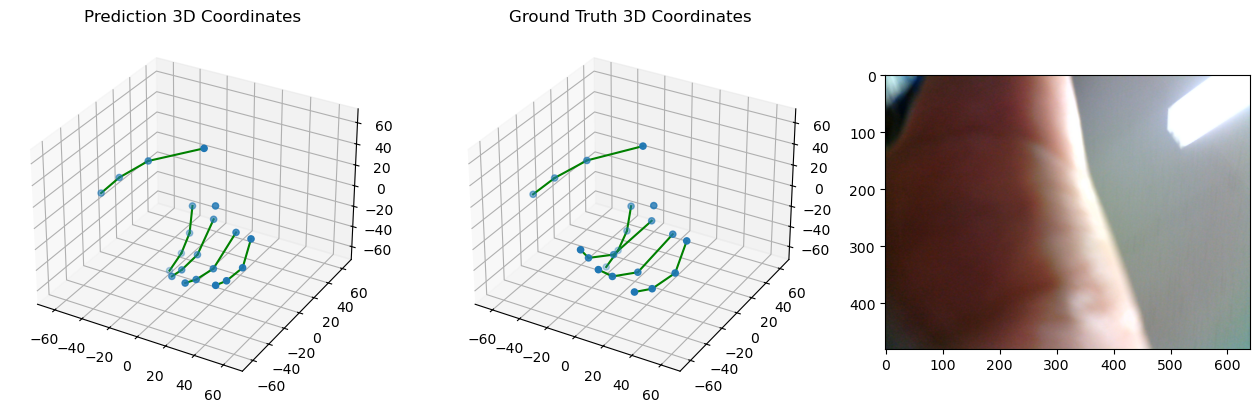

In [28]:
show_shape(test_dataset=test_dataset, model=model)

### Movement

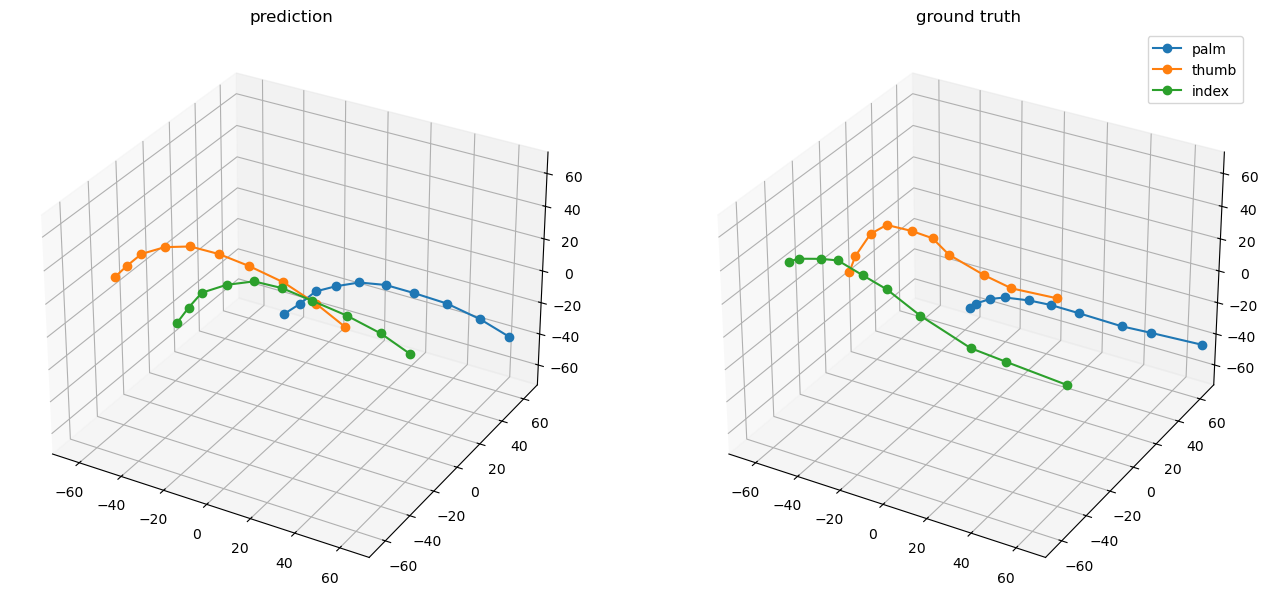

In [33]:
show_movement(test_dataset=test_dataset, model=model)

### Mono Movement

In [ ]:
show_mono_movement(test_dataset=test_dataset, model=model)

### Metrics
contains three metrics, [loss, shape accuracy, movment accuracy]

- Loss
    - in the training process, loss was calculated using MSE between the predicted 3D coordinates and the target ones.

- Shape Accuracy
    - calculate the shape accuracy of hand estimation
    - for each 21 key points of the hand(3D coordinates), calculate the MSE, and return the average of it
    - the last frame's hand was chosen as the target of key point

- Movement Accuracy
    - calculate the movement accuracy of hand estimation
    - chose three key points [root of thumb, root of index, center of palm], calculate the MSE, and return the average of it
    - the last frame's hand was chosen as the target of key point

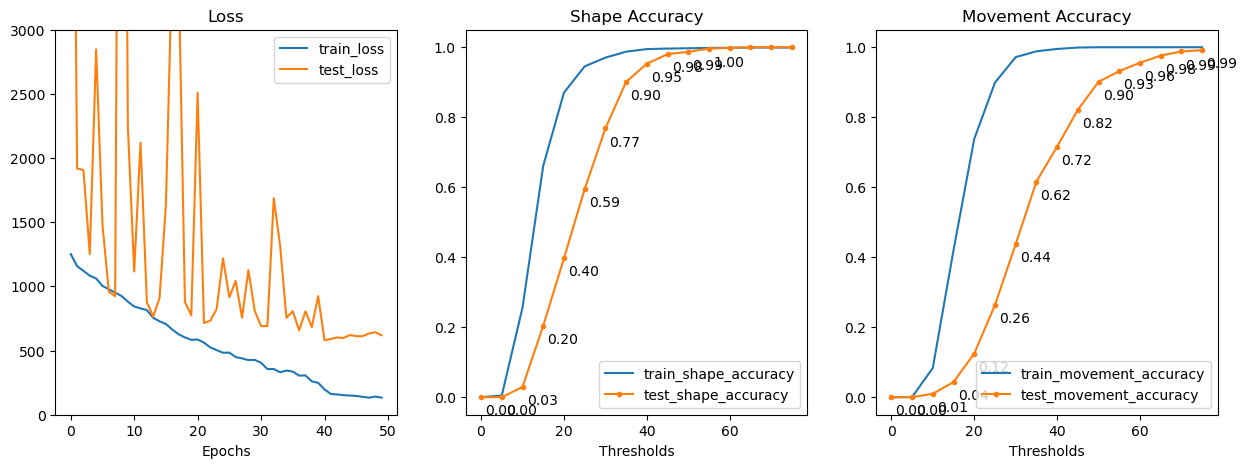

In [30]:
with open("./data/result.json") as f:
        model_result = json.load(f)

plot_loss_curves(model_result)